# Step‑by‑Step: Which Early‑Game Features Are Most Predictive of Winning?

This notebook combines the ideas from your **`LogisticRegression.ipynb`** and **`Importance_SHAP.ipynb`**:
- **Logistic Regression (with scaling)** for **direction + odds ratios**
- **Tree model + SHAP** for **nonlinear, interaction-aware importance**

We'll proceed in small, clear steps.

**Files expected:**
- Dataset CSV: `high_diamond_ranked_10min.csv` (same folder as this notebook)

## Step 0 — Setup

In [3]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier

print("Libraries loaded.")

Libraries loaded.


## Step 1 — Load data

In [4]:
DATA_PATH = "./project1/high_diamond_ranked_10min.csv"
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError("Put 'high_diamond_ranked_10min.csv' next to this notebook, or update DATA_PATH.")

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())

Shape: (9879, 40)


,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


## Step 2 — Target and basic checks

In [5]:
assert "blueWins" in df.columns, "Expected 'blueWins' column (1=blue win, 0=red win)."
y = df["blueWins"].astype(int)
print("Blue win rate:", y.mean())

# Keep numeric features only
X_num = df.drop(columns=["blueWins"]).select_dtypes(include=[np.number]).copy()
print("Numeric feature count:", X_num.shape[1])

# Quick missingness check
missing = X_num.isna().mean()
print("Columns with missing values:")
display(missing[missing>0].sort_values(ascending=False))
X_num = X_num.fillna(0)

Blue win rate: 0.4990383642069035
Numeric feature count: 39
Columns with missing values:


Series([], dtype: float64)

## Step 3 — Create Blue–Red difference features (symmetry, less redundancy)

In [6]:
# We auto-pair columns like 'blueGold' and 'redGold' and create diff = blue - red.
blue_cols = [c for c in X_num.columns if c.startswith("blue")]
red_cols = [c for c in X_num.columns if c.startswith("red")]

def red_partner(blue_name):  # 'blueGold' -> 'redGold'
    return "red" + blue_name[len("blue"):]

diffs = {}
for b in blue_cols:
    r = red_partner(b)
    if r in red_cols and np.issubdtype(X_num[b].dtype, np.number) and np.issubdtype(X_num[r].dtype, np.number):
        diffs["diff" + b[len("blue"):]] = X_num[b] - X_num[r]

X_diff = pd.DataFrame(diffs)
print("Created diff features:", X_diff.shape[1])
display(X_diff.head())

Created diff features: 19


,diffWardsPlaced,diffWardsDestroyed,diffFirstBlood,diffKills,diffDeaths,diffAssists,diffEliteMonsters,diffDragons,diffHeralds,diffTowersDestroyed,diffTotalGold,diffAvgLevel,diffTotalExperience,diffTotalMinionsKilled,diffTotalJungleMinionsKilled,diffGoldDiff,diffExperienceDiff,diffCSPerMin,diffGoldPerMin
0,13,-4,1,3,-3,3,0,0,0,0,643,-0.2,-8,-2,-19,1286,-16,-0.2,64.3
1,0,0,-1,0,0,3,-2,-1,-1,-1,-2908,-0.2,-1173,-66,-9,-5816,-2346,-6.6,-290.8
2,0,-3,-1,-4,4,-10,1,1,0,0,-1172,-0.4,-1033,-17,18,-2344,-2066,-1.7,-117.2
3,28,-1,-1,-1,1,-5,1,0,1,0,-1321,0.0,-7,-34,8,-2642,-14,-3.4,-132.1
4,58,2,-1,0,0,-1,-1,-1,0,0,-1004,0.0,230,-15,-10,-2008,460,-1.5,-100.4


## Step 4 — Train/Test split (stratified)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_diff, y, test_size=0.25, random_state=42, stratify=y)
print("Train size:", X_train.shape, " Test size:", X_test.shape)

Train size: (7409, 19)  Test size: (2470, 19)


## Step 5 — Logistic Regression (with scaling)

**Why scaling?** Logistic Regression coefficients are sensitive to feature scale.  
Standardizing to mean 0, std 1 makes coefficients comparable: a 1‑unit change is **1 standard deviation**.

Logistic Regression — Accuracy: 0.721  AUC: 0.811
              precision    recall  f1-score   support

           0      0.723     0.720     0.721      1237
           1      0.720     0.723     0.721      1233

    accuracy                          0.721      2470
   macro avg      0.721     0.721     0.721      2470
weighted avg      0.721     0.721     0.721      2470



,coef_std,odds_ratio_per_SD
diffTotalGold,0.431374,1.539371
diffGoldDiff,0.431374,1.539371
diffGoldPerMin,0.431374,1.539371
diffExperienceDiff,0.233383,1.262865
diffTotalExperience,0.233383,1.262865
diffDragons,0.186830,1.205422
diffEliteMonsters,0.123556,1.131513
diffAssists,-0.093705,0.910552
diffTowersDestroyed,-0.085272,0.918262
diffCSPerMin,-0.079442,0.923632


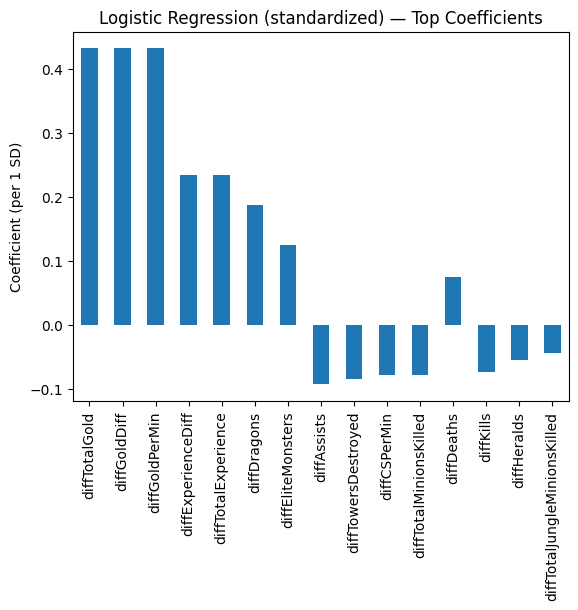

In [8]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=300, n_jobs=None)
logreg.fit(X_train_sc, y_train)

y_prob = logreg.predict_proba(X_test_sc)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print("Logistic Regression — Accuracy:", f"{acc:.3f}", " AUC:", f"{auc:.3f}")
print(classification_report(y_test, y_pred, digits=3))

# Coefficients -> odds ratios per 1 SD
coef = pd.Series(logreg.coef_[0], index=X_train.columns)
odds = np.exp(coef)
lr_importance = pd.DataFrame({"coef_std": coef, "odds_ratio_per_SD": odds}).sort_values("coef_std", key=lambda s: s.abs(), ascending=False)
display(lr_importance.head(15))

# Plot top coefficients
top15 = lr_importance.head(15).copy()
plt.figure()
top15["coef_std"].plot(kind="bar")
plt.title("Logistic Regression (standardized) — Top Coefficients")
plt.ylabel("Coefficient (per 1 SD)")
plt.xticks(rotation=90)
plt.show()

## Step 6 — Random Forest (nonlinear baseline)

Random Forest — Accuracy: 0.715  AUC: 0.796


diffTotalGold                   0.109544
diffGoldDiff                    0.108798
diffGoldPerMin                  0.105472
diffExperienceDiff              0.094012
diffTotalExperience             0.093123
diffTotalJungleMinionsKilled    0.056418
diffWardsPlaced                 0.055994
diffCSPerMin                    0.055774
diffTotalMinionsKilled          0.054337
diffAssists                     0.047228
diffDeaths                      0.043258
diffWardsDestroyed              0.038657
diffKills                       0.037601
diffAvgLevel                    0.034262
diffEliteMonsters               0.021658
dtype: float64

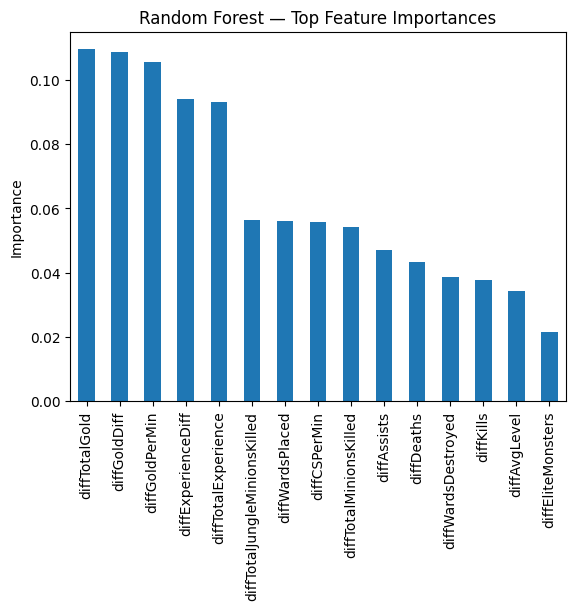

In [9]:
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
rf_prob = rf.predict_proba(X_test)[:,1]
rf_pred = (rf_prob >= 0.5).astype(int)

rf_acc = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_prob)
print("Random Forest — Accuracy:", f"{rf_acc:.3f}", " AUC:", f"{rf_auc:.3f}")

rf_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
display(rf_importance.head(15))

plt.figure()
rf_importance.head(15).plot(kind="bar")
plt.title("Random Forest — Top Feature Importances")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.show()

## Step 7 — SHAP for Interpretability (tree model)

In [10]:
try:
    import shap
    # TreeExplainer works well for random forest
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_test)

    # Global importance: mean(|SHAP|) per feature
    sv = shap_values[1] if isinstance(shap_values, list) else shap_values
    shap_abs_mean = np.abs(sv).mean(axis=0)
    shap_importance = pd.Series(shap_abs_mean, index=X_train.columns).sort_values(ascending=False)
    print("Top 15 SHAP (mean |value|):")
    display(shap_importance.head(15))

    # Summary bar plot
    shap.summary_plot(sv, X_test, plot_type="bar")
except Exception as e:
    print("SHAP not available or failed to plot:", e)
    shap_importance = pd.Series(dtype=float)

SHAP not available or failed to plot: Data must be 1-dimensional, got ndarray of shape (19, 2) instead


## Step 8 — Consensus ranking

Consensus top 15 features:


,LR,RF,consensus
diffTotalGold,1.000000,1.000000,1.000000
diffGoldDiff,1.000000,0.992895,0.996447
diffGoldPerMin,1.000000,0.961225,0.980612
diffExperienceDiff,0.527481,0.852105,0.689793
diffTotalExperience,0.527481,0.843639,0.685560
diffCSPerMin,0.160090,0.488011,0.324050
diffTotalMinionsKilled,0.160090,0.474324,0.317207
diffAssists,0.194129,0.406630,0.300380
diffTotalJungleMinionsKilled,0.075465,0.494136,0.284801
diffDragons,0.416379,0.121821,0.269100


Saved: feature_importance_consensus.csv


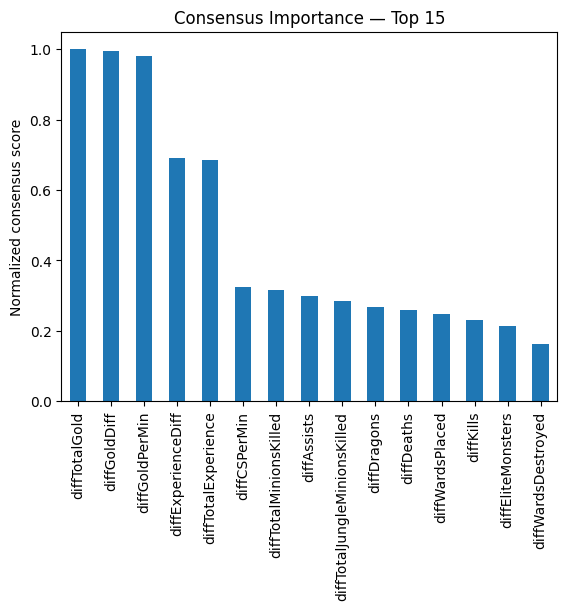

In [11]:
# Build a consensus by averaging normalized ranks across LR, RF, SHAP (available ones)
frames = []
# Logistic: absolute coefficient magnitude
if "lr_importance" in locals():
    r1 = lr_importance.copy()
    r1["score"] = r1["coef_std"].abs()
    r1 = r1[["score"]].rename(columns={"score":"LR"})
    frames.append(r1)
# RF
if "rf_importance" in locals():
    r2 = rf_importance.to_frame(name="RF")
    frames.append(r2)
# SHAP
if "shap_importance" in locals() and len(shap_importance)>0:
    r3 = shap_importance.to_frame(name="SHAP")
    frames.append(r3)

if frames:
    combo = pd.concat(frames, axis=1)
    # Normalize each column to [0,1] and average
    for col in combo.columns:
        m, M = combo[col].min(), combo[col].max()
        if M > m:
            combo[col] = (combo[col]-m)/(M-m)
    combo["consensus"] = combo.mean(axis=1)
    combo_sorted = combo.sort_values("consensus", ascending=False)
    print("Consensus top 15 features:")
    display(combo_sorted.head(15))

    # Save for reporting
    out_path = "feature_importance_consensus.csv"
    combo_sorted.to_csv(out_path)
    print("Saved:", out_path)

    plt.figure()
    combo_sorted["consensus"].head(15).plot(kind="bar")
    plt.title("Consensus Importance — Top 15")
    plt.ylabel("Normalized consensus score")
    plt.xticks(rotation=90)
    plt.show()
else:
    print("No importance objects available to build consensus.")

## How to interpret the outputs

- **Logistic Regression (scaled):** coefficients are per **1 standard deviation**.  
    - Positive ⇒ increasing the feature raises the odds of Blue winning.  
    - Negative ⇒ increasing the feature lowers the odds.  
    - `odds_ratio_per_SD = exp(coef)` tells how many times the odds change per 1 SD increase.

- **Random Forest importance:** how much a feature reduces impurity. Good for **nonlinear** signals.

- **SHAP (tree):** mean absolute SHAP value = average impact magnitude on the model's prediction.  
    - Summary bar plot ranks features globally.  
    - (Optional) `shap.summary_plot(sv, X_test)` gives a dot plot to see how high/low feature values push predictions.

- **Consensus ranking:** averages normalized importances to highlight features that are consistently important across methods.